# Swiss Bank Notes Counterfeit Detection
Welcome to my Jupyter Notebook focused on the analysis of Swiss Bank Notes. In this notebook, we will explore and examine various features of Swiss banknotes to gain insights and potentially detect patterns or anomalies related to their authenticity.

## Introduction
Swiss banknotes are renowned for their high quality and security features, which make them resistant to counterfeiting. However, it is essential to continually assess and improve the methods used to verify their authenticity, as counterfeiters become increasingly sophisticated in their techniques.

## Report Structure

The objective of this analysis is to leverage data-driven techniques, specifically different Clustering Algorithms, to investigate the characteristics of genuine Swiss banknotes and distinguish them from counterfeit ones. By utilizing a dataset that includes different features, we aim to identify meaningful clusters that can aid in the identification of counterfeit banknotes.

- **We will start with the Exploratory Data Analysis**
- **Then we'll look into Data Cleaning (if necessary)**
- **Finally we'll try our various Clustering models and fit our data accordingly**
- **Choose the Best Model for the production**

Throughout this notebook, we will explore the correlations between different features, select appropriate variables for clustering, and assess the effectiveness of the chosen approach in distinguishing genuine and counterfeit Swiss banknotes.

So let's dive into the analysis and discover the insights hidden within the features of Swiss banknotes!

## Aim:
***The aim of this project is to develop an accurate and reliable ML Model using different clustering algorithms and machine learning techniques.***

In [1]:
# Importing Necessary Libraries and Tools for the Project

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [2]:
# Supressing Warnings 

import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis (EDA)
Exploratory Data Analysis (EDA) plays a crucial role in any data-driven project, including detection of counterfeit bank notes using ML models. EDA involves investigating and understanding the characteristics, patterns, and relationships within the dataset before applying any ML algorithms.

In [3]:
df = pd.read_csv("/kaggle/input/swiss-banknote-conterfeit-detection/banknotes.csv", sep=',')
df.head()

,conterfeit,Length,Left,Right,Bottom,Top,Diagonal
0,0,214.8,131.0,131.1,9.0,9.7,141.0
1,0,214.6,129.7,129.7,8.1,9.5,141.7
2,0,214.8,129.7,129.7,8.7,9.6,142.2
3,0,214.8,129.7,129.6,7.5,10.4,142.0
4,0,215.0,129.6,129.7,10.4,7.7,141.8


**Let's have a glance at our data using df.info()**

In [4]:
df = df.rename(columns={'conterfeit':'counterfeit'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   counterfeit  200 non-null    int64  
 1   Length       200 non-null    float64
 2   Left         200 non-null    float64
 3   Right        200 non-null    float64
 4   Bottom       200 non-null    float64
 5   Top          200 non-null    float64
 6   Diagonal     200 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 11.1 KB


**We can see that the dataset includes information about the shape of the bill, as well as the label. 
It is made up of 200 banknotes in total.**

**Attributes:**
- counterfeit: Wether a banknote is counterfeit (1) or genuine (0)
- Length: Length of bill (mm)
- Left: Width of left edge (mm)
- Right: Width of right edge (mm)
- Bottom: Bottom margin width (mm)
- Top: Top margin width (mm)
- Diagonal: Length of diagonal (mm)



#### Now let's check the distribution of Bank Notes in our dataset.
So, before working on with out dataset we should know whether out dataset has unbalanced classes or not, if it has, then we'll have to balance the distributions using some sampling techniques to make sure that out model won't be overfitted.

Text(0, 0.5, 'Frequency')

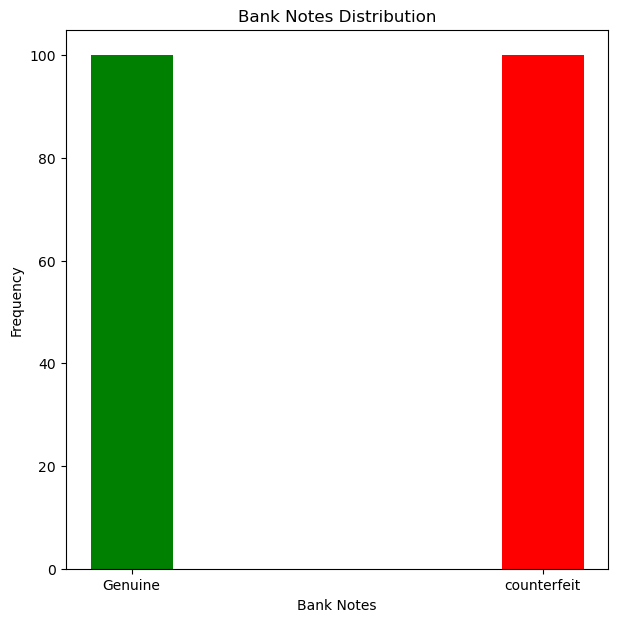

In [5]:
notes = df['counterfeit'].value_counts()
plt.figure(figsize=(7,7))
plt.bar(['Genuine', 'counterfeit'], notes, color=['green', 'red'], width=0.2)
plt.title("Bank Notes Distribution")
plt.xlabel('Bank Notes')
plt.ylabel("Frequency")


**Luckily, we've a balanced target variable. Hence, we don't need any Sampling methods to Model Unbalanced Data.** 
#### Now let's see the pattern Notes have with respect to Left, Right, Bottom & Top 

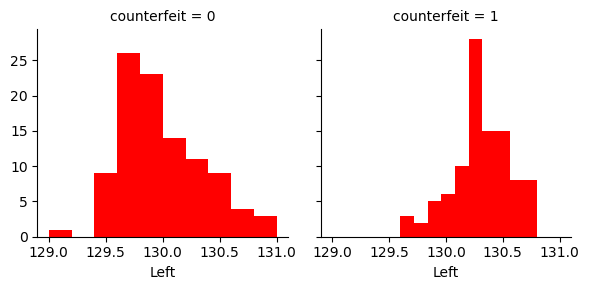

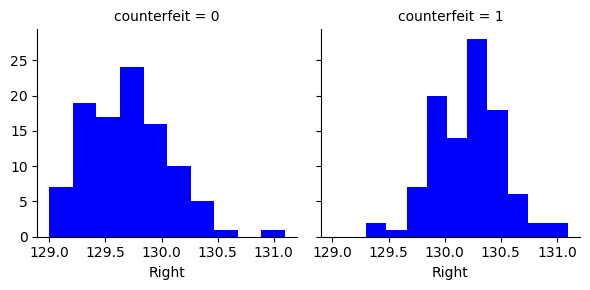

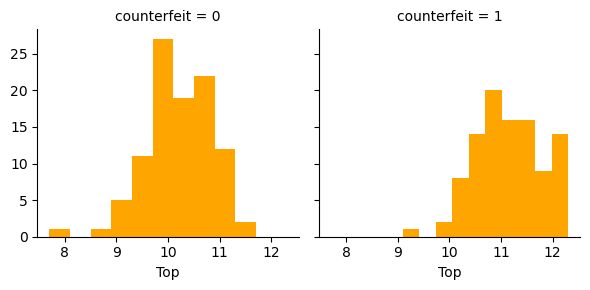

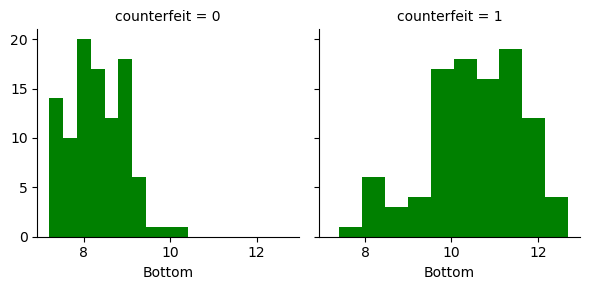

In [6]:
# Notes distribution w.r.t different dimensions
plot = sns.FacetGrid(df, col='counterfeit', margin_titles=True)
plot.map(plt.hist, 'Left', color='red')

plot = sns.FacetGrid(df, col='counterfeit', margin_titles=True)
plot.map(plt.hist, 'Right', color='blue')

plot = sns.FacetGrid(df, col='counterfeit', margin_titles=True)
plot.map(plt.hist, 'Top', color='orange')

plot = sns.FacetGrid(df, col='counterfeit', margin_titles=True)
plot.map(plt.hist, 'Bottom', color='green')
plt.show()

**From the above plot, we can gain some important insights:**
- The Most of the fake bills have **left-edge** width > 130mm
- The Most of the fake bills have **bottom-edge** width > 10mm

However, **right & top edges** have almost equal widgths, hence can't be distinguished visually.




# Data Cleaning
#### Let's Start this by Handling Missing Values

In [7]:
totalMissingVals = df.isnull().sum().sort_values(ascending=True)
totalMissingVals

counterfeit    0
Length         0
Left           0
Right          0
Bottom         0
Top            0
Diagonal       0
dtype: int64

Voila! We can see that we don't have any missing values.

#### Checking Duplicates

In [8]:
df.index.is_unique

True

So, our dataset is free from any duplicate values.

#### Handling Outliers
Let's check if there exists any possible outliers in Length, as it is the only feature that will have much more importance in our dataset.

<Axes: >

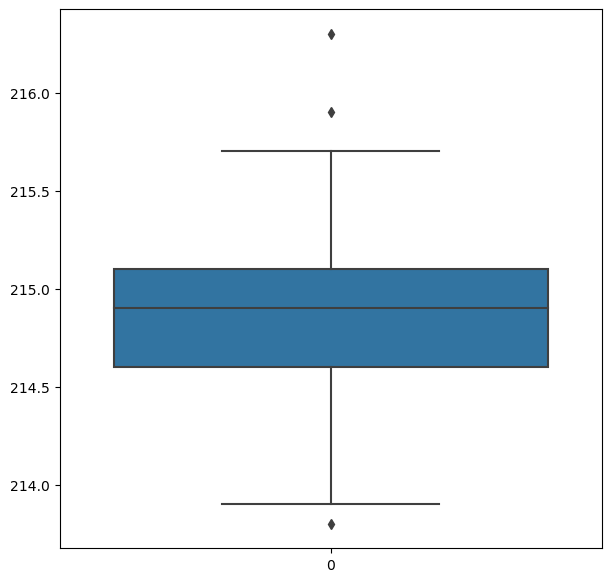

In [9]:
plt.figure(figsize=(7,7))
sns.boxplot(df.Length)

Hence, this 3 outliers won't affect much in out model. Still we would update them with the mean of the Length.

In [10]:
outliers = df[df['Length'] > 215.7]
outliers

,counterfeit,Length,Left,Right,Bottom,Top,Diagonal
34,0,215.9,130.4,130.0,8.9,10.6,141.4
166,1,216.3,130.7,130.4,10.0,10.1,138.8


<Axes: >

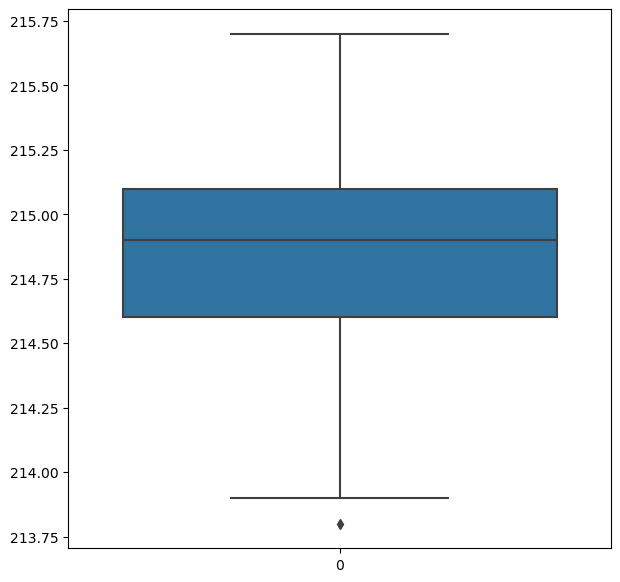

In [11]:
df.loc[df['Length'] > 215.7, 'Length'] = df['Length'].mean()
plt.figure(figsize=(7,7))
sns.boxplot(df.Length)

**From the above boxplot, we can see that we've removed the possible outliers.**

# Data Preprocessing

**Before feeding the Data into the Model, we must assure that the Dataset is Preprocessed.**

## Feature Engineering
A critical part of the successful Machine Learning project is coming up with a good set of features to train on. This process is called feature engineering, and it involves three steps: feature transformation (transforming the original features), feature selection (selecting the most useful features to train on), and feature extraction (combining existing features to produce more useful ones.

#### Now let's examine the correlation and skew of the relevant variables.

In [12]:
new_cols = [x for x in df.columns if x not in ['counterfeit']]

# The correlation matrix

corr_mat = df[new_cols].corr()
corr_mat

,Length,Left,Right,Bottom,Top,Diagonal
Length,1.000000,0.202005,0.137280,-0.203722,-0.050395,0.223255
Left,0.202005,1.000000,0.743263,0.413781,0.362350,-0.503229
Right,0.137280,0.743263,1.000000,0.486758,0.400670,-0.516476
Bottom,-0.203722,0.413781,0.486758,1.000000,0.141851,-0.622983
Top,-0.050395,0.362350,0.400670,0.141851,1.000000,-0.594045
Diagonal,0.223255,-0.503229,-0.516476,-0.622983,-0.594045,1.000000


Now let's **strip diagonal values in a correlation matrix**, This is done to focus on the **pairwise correlations** between different variables and remove the correlations of variables with themselves. In a correlation matrix, the diagonal represents the correlation of each variable with itself, which will always be 1. 

**Removing these diagonal values simplifies the matrix and allows for clearer visualization of the relationships between different variables.**

In [13]:
for x in range(len(new_cols)):
    corr_mat.iloc[x,x] = 0.0
    
corr_mat

,Length,Left,Right,Bottom,Top,Diagonal
Length,0.000000,0.202005,0.137280,-0.203722,-0.050395,0.223255
Left,0.202005,0.000000,0.743263,0.413781,0.362350,-0.503229
Right,0.137280,0.743263,0.000000,0.486758,0.400670,-0.516476
Bottom,-0.203722,0.413781,0.486758,0.000000,0.141851,-0.622983
Top,-0.050395,0.362350,0.400670,0.141851,0.000000,-0.594045
Diagonal,0.223255,-0.503229,-0.516476,-0.622983,-0.594045,0.000000


In [14]:
# Pairwise maximal correlations

corr_mat.abs().idxmax()

Length      Diagonal
Left           Right
Right           Left
Bottom      Diagonal
Top         Diagonal
Diagonal      Bottom
dtype: object

**Let's also construct the `heatmap()` with the correlation matrix.**

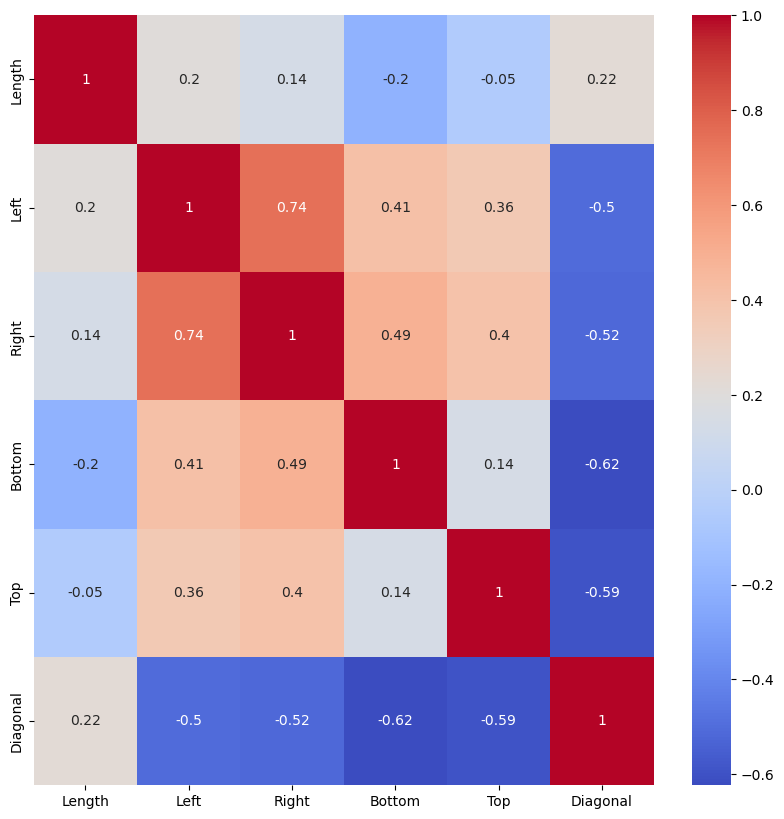

In [15]:
plt.figure(figsize=(10,10))
sns.heatmap(df[new_cols].corr(), annot=True, cmap='coolwarm')
plt.show()

**Insights :**
- We have Pairwise maximal correlations as **Length & Diagonal** follwed by **Left & Right**
- From the above **heatmap()** we can also see the same, hence **Left & Right** can be used as **v1 & v2** in **KMeans Clustering**.

#### Similarly examining the skewness for the same

In [16]:
skew_columns = (df[new_cols]
                .skew()
                .sort_values(ascending=False))

skew_columns = skew_columns.loc[skew_columns > 0.75]
skew_columns

Series([], dtype: float64)

**Luckily we see that our features are not skewed, hence any further transformations is not needed.**

## Feature Scaling
Let's perform Standard Scaling to our dataset.

In [17]:
scaler = StandardScaler()
df[new_cols] = scaler.fit_transform(df[new_cols])

df.head()

,counterfeit,Length,Left,Right,Bottom,Top,Diagonal
0,0,-0.236490,2.439452,2.837043,-0.289732,-1.186735,0.449372
1,0,-0.799831,-1.170437,-0.636381,-0.914304,-1.436443,1.058395
2,0,-0.236490,-1.170437,-0.636381,-0.497923,-1.311589,1.493412
3,0,-0.236490,-1.170437,-0.884483,-1.330685,-0.312759,1.319405
4,0,0.326850,-1.448121,-0.636381,0.681824,-3.683811,1.145399


***Now, drawing pairplot of the scaled features***




<Figure size 1000x1000 with 0 Axes>

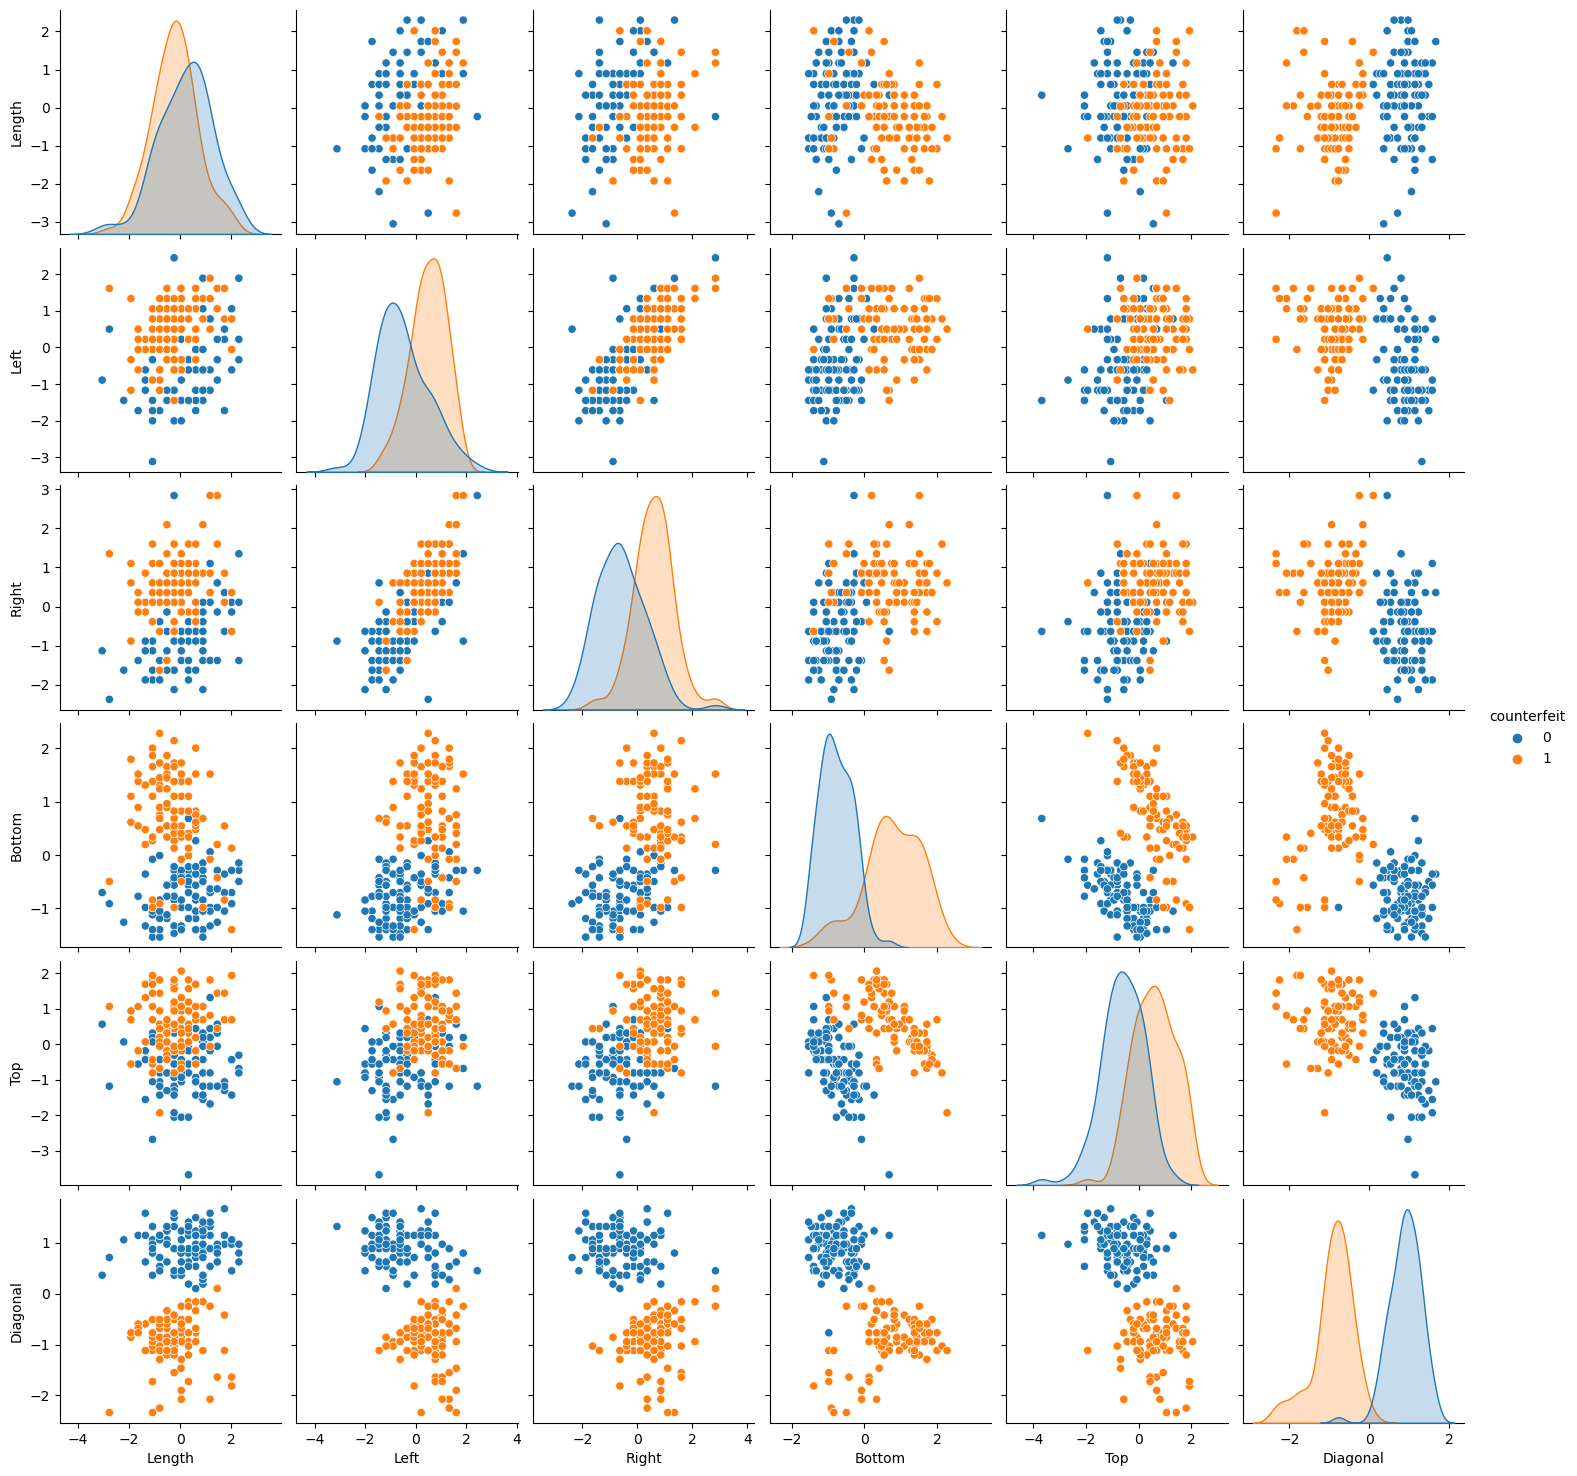

In [18]:
plt.figure(figsize=(10,10))
sns.pairplot(df[new_cols + ['counterfeit']], 
             hue="counterfeit");

**Hence, we can see the distributions w.r.t the Bank Notes, using the pairplot.**

# Modelling

### Data Preparation
We'll use **Right & Left** features as they were highly correlated.

Text(0, 0.5, 'Right')

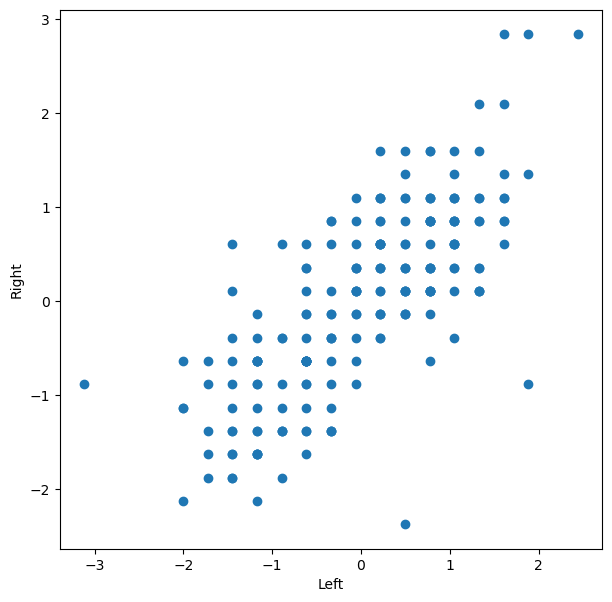

In [19]:
plt.figure(figsize = [7, 7])
plt.scatter(df.Left, df.Right);
plt.xlabel("Left")
plt.ylabel("Right")

In [20]:
data = np.column_stack(( df.Right, df.Left))

# KMeans Clustering

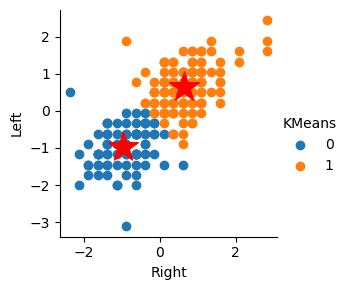

In [21]:
KM = KMeans(n_clusters = 2, random_state = 42)
KM = KM.fit(data)

clusters = KM.cluster_centers_

df['KMeans'] = KM.labels_

g = sns.FacetGrid(data = df, hue = 'KMeans')
g.map(plt.scatter, 'Right', 'Left')
g.add_legend();
plt.scatter(clusters[:,0], clusters[:,1], s = 500, marker='*', c='r');

**Let's re-run KMeans several times to check if the K-Means model is stable in our the dataset.**

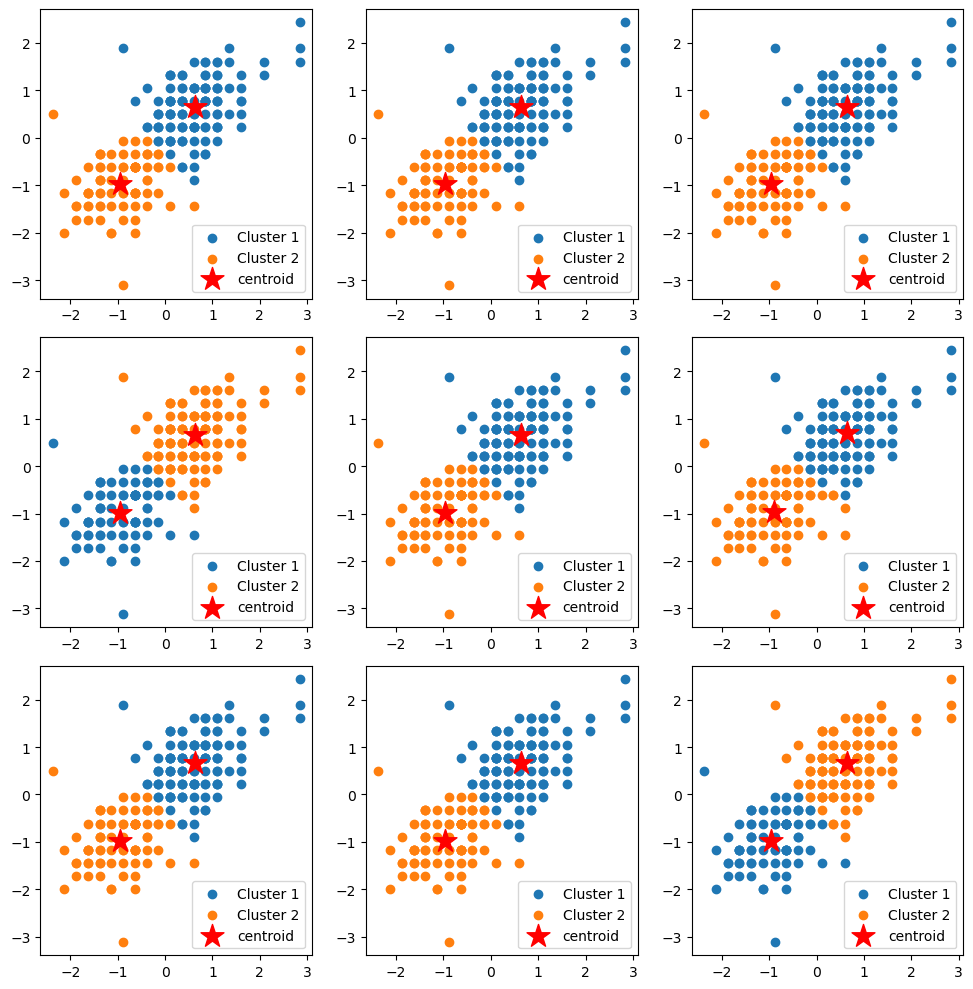

In [22]:
n_iter = 9
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
ax = np.ravel(ax)
results = []
for i in range(n_iter):
    KM = KMeans(n_clusters=2,
                max_iter=3)
    KM.fit(data)
    centroids = KM.cluster_centers_
    
    results.append(centroids)
    ax[i].scatter(data[KM.labels_ == 0, 0], data[KM.labels_ == 0, 1],
                   label='Cluster 1')
    ax[i].scatter(data[KM.labels_ == 1, 0], data[KM.labels_ == 1, 1],
                   label='Cluster 2')
    ax[i].scatter(centroids[:, 0], centroids[:, 1],
                  c='r', marker='*', s=300, label='centroid')
    ax[i].legend(loc='lower right')
    ax[i].set_aspect('equal')
plt.tight_layout();

### After running K-Means several times the results we got are very similar, which means the K-Means here are stable.
Now let's describe the KMeans feature.

In [23]:
df.groupby('KMeans').describe()

counterfeit                                              Length  \
             count      mean       std  min  25%  50%  75%  max  count   
KMeans                                                                   
0             80.0  0.150000  0.359324  0.0  0.0  0.0  0.0  1.0   80.0   
1            120.0  0.733333  0.444071  0.0  0.0  1.0  1.0  1.0  120.0   

                  ...       Top           Diagonal                      \
            mean  ...       75%       max    count      mean       std   
KMeans            ...                                                    
0      -0.106218  ...  0.061803  2.059463     80.0  0.651655  0.788429   
1       0.070812  ...  0.966993  1.934610    120.0 -0.434437  0.890055   

                                                          
             min       25%       50%       75%       max  
KMeans                                                    
0      -1.812714  0.536375  0.884389  1.145399  1.580415  
1      -2.334734 -0.942681 -0.594668  0.210113  1.667419  

[2 rows x 56 columns]

#### Determining the Number of Clusters we would actually need.

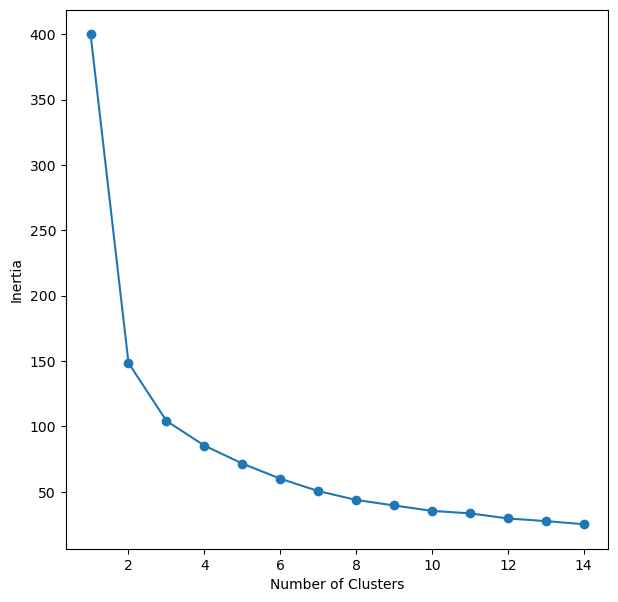

In [24]:
inertia = []
list_num_clusters = list(range(1,15))
for num_clusters in list_num_clusters:
    KM = KMeans(n_clusters=num_clusters)
    KM.fit(data)
    inertia.append(KM.inertia_)
    
plt.figure(figsize=(7,7))    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

**From the elbow of the curve we can see that 2 clusters will be best for our model.**

### Analysis of the KMeans Clustering Model

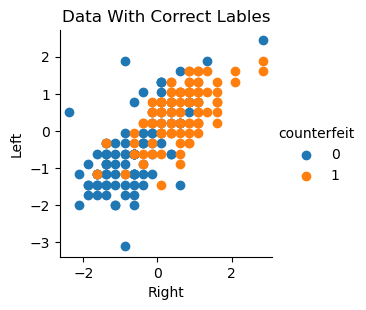

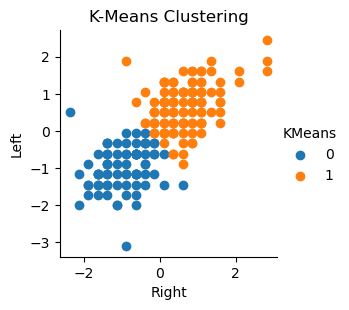

In [25]:
g = sns.FacetGrid(data = df[df.columns], hue = 'counterfeit')
g.map(plt.scatter, 'Right', 'Left')
g.add_legend()
plt.title("Data With Correct Lables")


# plot the data computed by K-Means
g = sns.FacetGrid(data = df, hue = 'KMeans')
g.map(plt.scatter, 'Right', 'Left')
g.add_legend()
plt.title("K-Means Clustering");

In [26]:
# calculating the Accuracy of the model.
correct = 0

for i in range(0,200):
    if df.counterfeit[i] == df["KMeans"][i]:
        correct+=1
        
print(f"Accuracy of the Model : {correct/200 * 100}%")

Accuracy of the Model : 78.0%


### We can find that KMeans Clustering nearly clusters with almost **78%** w.r.t original dataset.

# Mean Shift Clustering
Now before applying Mean Shift Clustering, we would have to estimate the bandwidth.

In [27]:
df = df.drop('KMeans', axis=1)

In [28]:
df_ms = df[new_cols].copy()
print("Shape: ",df_ms.shape)
print("Data Type : ", df_ms.dtypes)

Shape:  (200, 6)
Data Type :  Length      float64
Left        float64
Right       float64
Bottom      float64
Top         float64
Diagonal    float64
dtype: object


Let's estimate the bandwidth to use with the Mean-Shift algorithm, using the <code>estimate_bandwidth</code> function:

In [29]:
bandwidth = estimate_bandwidth(df_ms, quantile=.06, n_samples=200)
bandwidth 

1.5182706478678574

Let's apply the **bandwidth** on the Mean shift algorithm.

In [30]:
MS = MeanShift(bandwidth=bandwidth,bin_seeding=True)
MS.fit(df_ms)

MeanShift(bandwidth=1.5182706478678574, bin_seeding=True)

Now the number of clusters,

In [31]:
labels = MS.labels_
num_clusters = len(set(labels))

print("Number of clusters:", num_clusters)

Number of clusters: 14


**Plotting the Mean Shift Clusters**

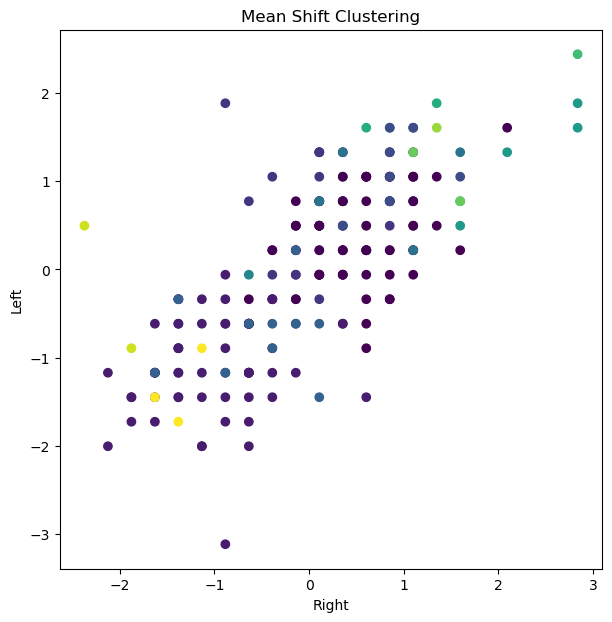

In [32]:
plt.figure(figsize=(7,7))
plt.scatter(df_ms['Right'], df_ms['Left'], c=labels)
plt.title('Mean Shift Clustering')
plt.xlabel('Right')
plt.ylabel('Left')
plt.show()

### Now, Let's compare it with the Original Counterfeit notes

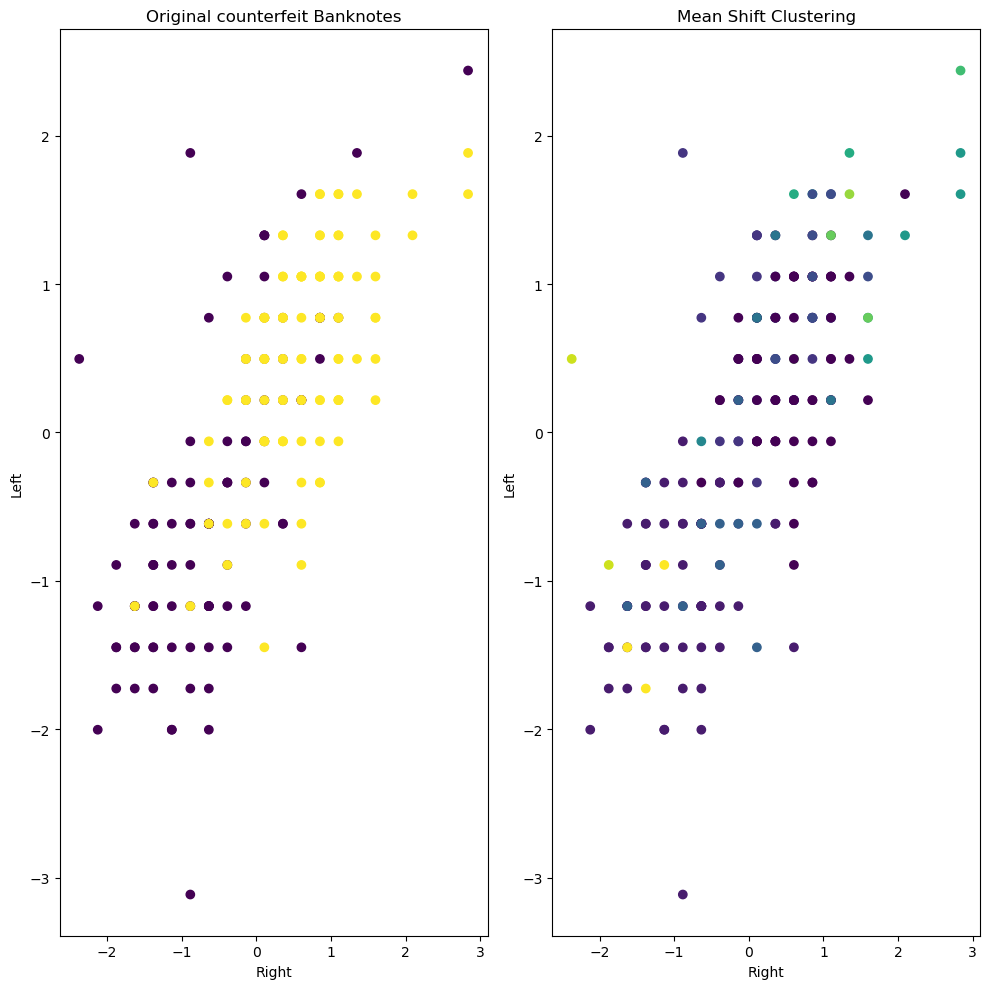

In [33]:
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.scatter(df['Right'], df['Left'], c=df['counterfeit'])
plt.title('Original counterfeit Banknotes')
plt.xlabel('Right')
plt.ylabel('Left')

# Plotting the clusters from Mean Shift
plt.subplot(1, 2, 2)
plt.scatter(df_ms['Right'], df_ms['Left'], c=labels)
plt.title('Mean Shift Clustering')
plt.xlabel('Right')
plt.ylabel('Left')

plt.tight_layout()
plt.show()

### Accuracy using Mean-Shift
Let's find the Silhouette Score

In [34]:
silhouette_avg = silhouette_score(df_ms, labels)

print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.12682064445283436


#### Hence, we can see that Mean-Shift clustered our dataset very poorely.

# DBSCAN
### (Density Based Spacial Clustering of Applications with Noise)

In [35]:
df_dbs = df.copy()
df_dbs

,counterfeit,Length,Left,Right,Bottom,Top,Diagonal
0,0,-0.236490,2.439452,2.837043,-0.289732,-1.186735,0.449372
1,0,-0.799831,-1.170437,-0.636381,-0.914304,-1.436443,1.058395
2,0,-0.236490,-1.170437,-0.636381,-0.497923,-1.311589,1.493412
3,0,-0.236490,-1.170437,-0.884483,-1.330685,-0.312759,1.319405
4,0,0.326850,-1.448121,-0.636381,0.681824,-3.683811,1.145399
...,...,...,...,...,...,...,...
195,1,0.326850,0.773349,0.852229,0.334840,1.809756,-0.768674
196,1,0.608520,0.495666,-0.140177,0.612427,1.060633,-0.681671
197,1,-0.236490,0.495666,1.100331,0.820618,0.561218,-0.420661
198,1,-0.518160,1.606401,2.092738,1.236999,0.686072,-0.942681


In [36]:
# Using DBSCAN clustering
DBS = DBSCAN(eps=0.1, metric='euclidean', min_samples=5)
DBS = DBS.fit(df[['Right', 'Left']])

**Number of clusters found according to DBSCAN**

In [37]:
print(f'Clusters : {len(set(DBS.labels_) - set([-1]))}')

Clusters : 5


**Visualizing the clusters**

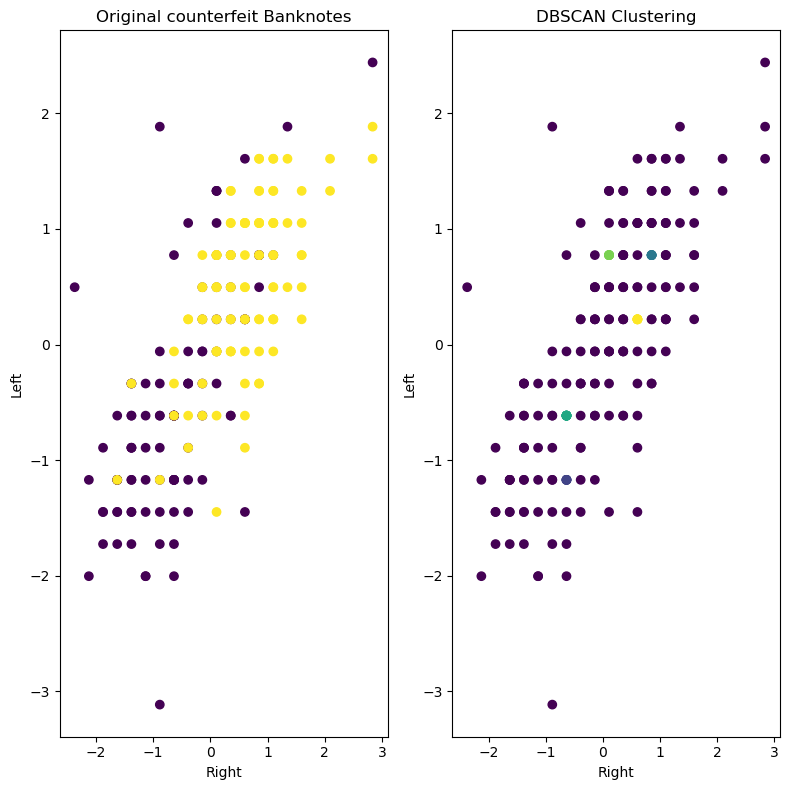

In [38]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.scatter(df['Right'], df['Left'], c=df['counterfeit'])
plt.title('Original counterfeit Banknotes')
plt.xlabel('Right')
plt.ylabel('Left')

# Plotting the clusters from Mean Shift
plt.subplot(1, 2, 2)
plt.scatter(df_ms['Right'], df_ms['Left'], c=DBS.labels_)
plt.title('DBSCAN Clustering')
plt.xlabel('Right')
plt.ylabel('Left')

plt.tight_layout()
plt.show()

**Hence, our DBSCAN model also doesn't clusters counterfeit Bank Notes w.r.t the original dataset.**

# Gausian Mixture Model
Gaussian Mixture Models (GMM) is a clustering algorithm that fits a weighted combination of Gaussian distributions to our data.

In [39]:
df_gmm = df.copy()
df_gmm

,counterfeit,Length,Left,Right,Bottom,Top,Diagonal
0,0,-0.236490,2.439452,2.837043,-0.289732,-1.186735,0.449372
1,0,-0.799831,-1.170437,-0.636381,-0.914304,-1.436443,1.058395
2,0,-0.236490,-1.170437,-0.636381,-0.497923,-1.311589,1.493412
3,0,-0.236490,-1.170437,-0.884483,-1.330685,-0.312759,1.319405
4,0,0.326850,-1.448121,-0.636381,0.681824,-3.683811,1.145399
...,...,...,...,...,...,...,...
195,1,0.326850,0.773349,0.852229,0.334840,1.809756,-0.768674
196,1,0.608520,0.495666,-0.140177,0.612427,1.060633,-0.681671
197,1,-0.236490,0.495666,1.100331,0.820618,0.561218,-0.420661
198,1,-0.518160,1.606401,2.092738,1.236999,0.686072,-0.942681


**Fitting Gaussian Mixture Model**

In [40]:
GMM = GaussianMixture(n_components=3, random_state=0).fit(df_gmm)
clusters_gmm = GMM.predict(df)
clusters_gmm

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0,
       0, 0])

**Let's plot the Gaussian Mixture Model w.r.t to the original counterfeit bank notes.**

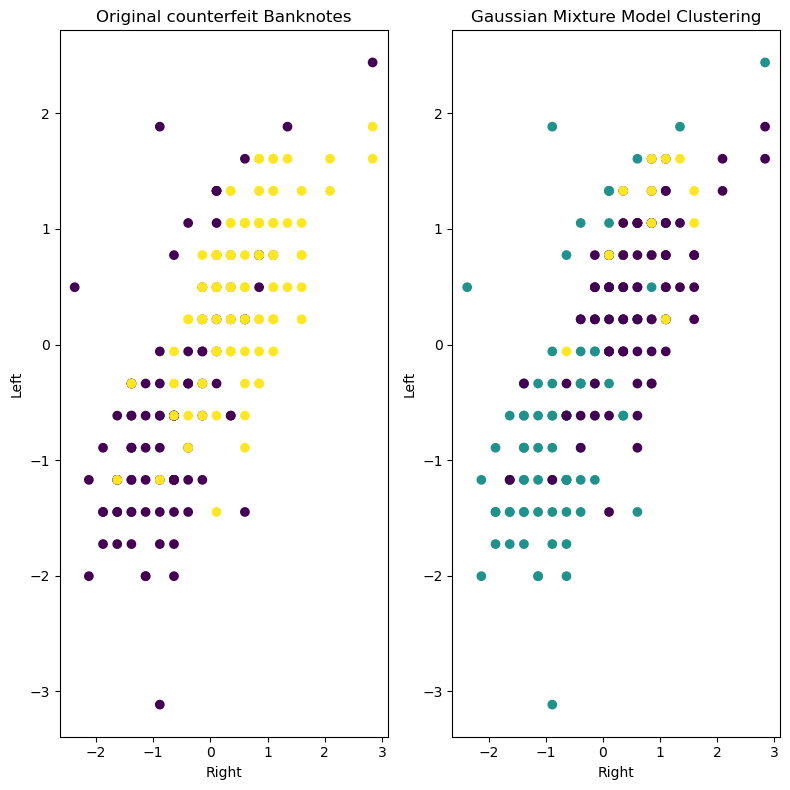

In [41]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.scatter(df['Right'], df['Left'], c=df['counterfeit'])
plt.title('Original counterfeit Banknotes')
plt.xlabel('Right')
plt.ylabel('Left')

plt.subplot(1, 2, 2)
plt.scatter(df_ms['Right'], df_ms['Left'], c=clusters_gmm)
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('Right')
plt.ylabel('Left')

plt.tight_layout()
plt.show()

### So, we can see that Gaussian Mixture Model also performs better than DBSCAN and Mean Shift Algorithms.

# Best Model

### We can see from the above modelling analysis that KMeans performed the best comparing to the rest of the algorithms.
**Now let's try some dimensional reduction techniques like PCA to our model.**

Now we'll use PCA to KMeans to find clusters in the dataset without using the counterfeit column to see if it will be capable to separate well the dataset in two clusters.

In [42]:
df_kmeans = df.copy()
df_kmeans = df_kmeans.drop("counterfeit", axis=1)

In [43]:
df_kmeans

,Length,Left,Right,Bottom,Top,Diagonal
0,-0.236490,2.439452,2.837043,-0.289732,-1.186735,0.449372
1,-0.799831,-1.170437,-0.636381,-0.914304,-1.436443,1.058395
2,-0.236490,-1.170437,-0.636381,-0.497923,-1.311589,1.493412
3,-0.236490,-1.170437,-0.884483,-1.330685,-0.312759,1.319405
4,0.326850,-1.448121,-0.636381,0.681824,-3.683811,1.145399
...,...,...,...,...,...,...
195,0.326850,0.773349,0.852229,0.334840,1.809756,-0.768674
196,0.608520,0.495666,-0.140177,0.612427,1.060633,-0.681671
197,-0.236490,0.495666,1.100331,0.820618,0.561218,-0.420661
198,-0.518160,1.606401,2.092738,1.236999,0.686072,-0.942681


### Applying PCA

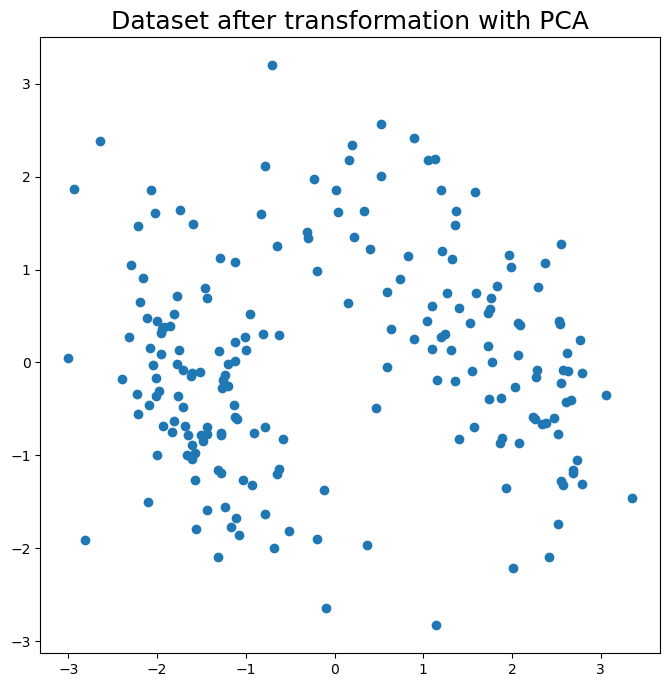

In [44]:
pca = PCA()

transformed_data = pca.fit_transform(df_kmeans)

plt.figure(figsize=(8,8))
plt.scatter(x = transformed_data[:,0], y = transformed_data[:,1])
plt.title("Dataset after transformation with PCA", fontsize = 18)
plt.show()

### Clustering with KMeans after PCA

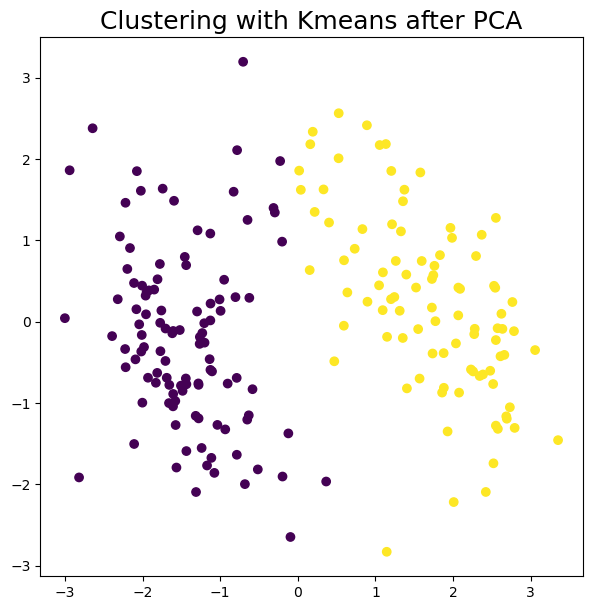

In [45]:
KM = KMeans(n_clusters = 2)
c = KM.fit_predict(transformed_data)

plt.figure(figsize=(7,7))
plt.scatter(x = transformed_data[:,0], y = transformed_data[:,1], c = c)
plt.title("Clustering with Kmeans after PCA", fontsize = 18)
plt.show()

### Hence we can see that clustering is even more accurate after applying Dimentionality Reduction, i.e applying PCA

# Summary

- In this analysis, I conducted **Exploratory Data Analysis (EDA)** on a Swiss Bank Notes dataset, followed by **Data cleaning** and **Preprocessing**. The dataset contained features related to banknotes dimensions, and **the objective was to perform clustering for counterfeit banknote detection**.

- I started by exploring the dataset and gaining insights into the distribution and relationships between variables. Then, I applied **K-means clustering**, which yielded a prediction accuracy of 78%. K-means performed well in identifying distinct clusters within the data, effectively separating genuine and counterfeit banknotes.

- Next, I explored other clustering approaches such as **DBSCAN, GMM, and Mean shift**. However, these methods did not perform as well as K-means in this specific analysis, indicating that **K-means was better suited** for the given dataset.

- To further **improve the performance of K-means clustering**, I applied **Principal Component Analysis (PCA)** to reduce the dimensionality of the dataset. By reducing the number of features and capturing the most significant variations, PCA can enhance clustering results. The application of PCA to K-means clustering allowed for a more concise representation of the data while preserving its clustering structure.

- Overall, based on the analysis, **K-means clustering with an accuracy of 78% proved to be the most effective approach for detecting counterfeit banknotes in this dataset**. Additionally, applying PCA to K-means clustering further improved its clustering performance by reducing the dimensionality of the data. These findings provide valuable insights for future applications of clustering algorithms in counterfeit banknote detection.

### Vulnerabilities that can be improved

- **Evaluation Metrics:** While the accuracy metric was used to assess the performance of the clustering models, it may not capture the full picture. Additional evaluation metrics specific to clustering, such as Calinski-Harabasz index, or Davies-Bouldin index, could provide more comprehensive insights into the quality and separation of the clusters.

- **Hybrid Approaches:** Instead of relying solely on clustering algorithms, combining clustering with supervised learning techniques, such as classification algorithms, may provide a more comprehensive approach for counterfeit banknote detection. This would involve training a classification model using labeled data to complement the clustering results.

- **Domain Expertise:** Incorporating domain knowledge and expertise in counterfeit banknote detection can greatly enhance the model's performance. This may involve considering additional features, such as security features or specific characteristics of counterfeit banknotes, that are not captured in the dataset used in this analysis.

By addressing these vulnerabilities and incorporating the suggested improvements, the model's performance can be further enhanced, leading to more accurate and reliable counterfeit banknote detection.

## Thank You :)